In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp

In [3]:
@pims.pipeline
def gray(image):
    return image[:, :, 1]  # Take just the green channel

frames = gray(pims.open("/Users/georgedamoulakis/PycharmProjects/TrackPy_walkthrough/pics_from_tamal/*.png"))

In [4]:
frames

(ImageSequence,) processed through proc_func. Original repr:
    <Frames>
    Source: /Users/georgedamoulakis/PycharmProjects/TrackPy_walkthrough/pics_from_tamal/*.png
    Length: 13 frames
    Frame Shape: (200, 400, 3)
    Pixel Datatype: uint8

In [5]:
print(frames[0])  # the first frame

[[114 114 114 ...  97  96  93]
 [113 113 113 ... 102 100  98]
 [112 112 112 ... 104 103 102]
 ...
 [108 108 108 ...  85  92  97]
 [106 107 107 ...  91  95 100]
 [109 110 109 ... 100 102 104]]


Frame([[114, 114, 114, ...,  97,  96,  93],
       [113, 113, 113, ..., 102, 100,  98],
       [112, 112, 112, ..., 104, 103, 102],
       ...,
       [108, 108, 108, ...,  85,  92,  97],
       [106, 107, 107, ...,  91,  95, 100],
       [109, 110, 109, ..., 100, 102, 104]], dtype=uint8)
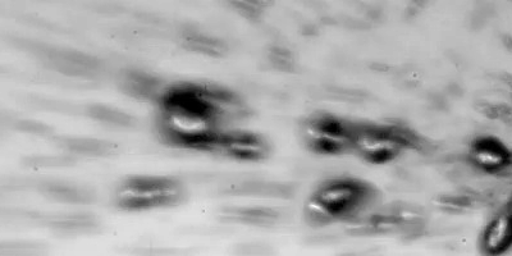

In [6]:
frames[0]

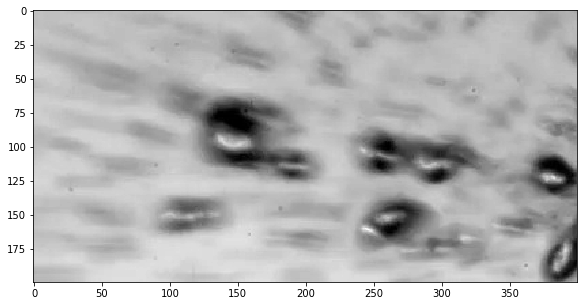

In [7]:
plt.imshow(frames[0]);

In [8]:
frames[3].frame_no

3

In [9]:
frames[3].metadata  # Scientific formats can pass experiment meta data here.

{}

Step 2: Locate Features
Start with just the first frame. Estimate the size of the features (in pixels). The size must be an odd integer, and it is better to err on the large side, as we'll see below. We estimate 11 pixels.

In [15]:
f = tp.locate(frames[0], 51, invert=True)

The algorithm looks for bright features; since the features in this set of images are dark, we set invert=True.
locate returns a spreadsheet-like object called a DataFrame. It lists
each feature's position,
various characterizations of its appearance, which we will use to filter out spurious features,
the "signal" strength and an estimate of uncertainty, both derived from this paper
More information about DataFrames may be found in the pandas documentation. DataFrames can easily be exported to formats like CSV, Excel, SQL, HDF5, etc.

In [11]:
f.head()  # shows the first few rows of data

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,18.914894,112.483671,3372.561072,11.320678,0.185993,12.515689,186209.0,NaN,0
1,32.051568,156.237145,9314.454090,11.137351,0.430686,25.309505,194889.0,NaN,0
2,44.565899,218.830408,6100.703209,8.683968,0.176606,23.084494,191750.0,NaN,0
3,49.675443,60.840774,7289.137438,11.314884,0.346416,16.131333,193771.0,NaN,0
4,56.455266,309.321653,4246.434310,12.314715,0.567288,17.521965,187002.0,NaN,0


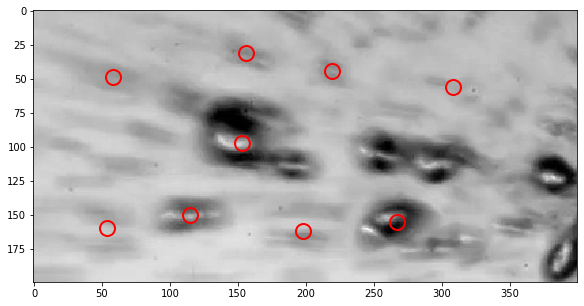

In [16]:
tp.annotate(f, frames[0]);

Refine parameters to elminate spurious features
Many of these circles are clearly wrong; they are fleeting peaks in brightness that aren't actually particles. Rejecting them often improves results and speeds up feature-finding. There are many ways to distinguish real particles from spurious ones. The most important way is to look at total brightness ("mass").

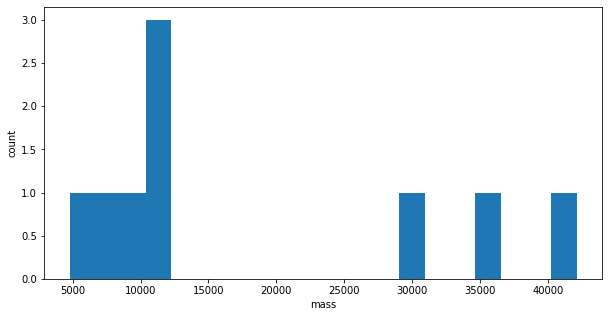

In [17]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

We can then specify the minmass parameter. If your image is especially noisy, you may also find the threshold parameter useful.

In [18]:
f = tp.locate(frames[0], 11, invert=True, minmass=300)

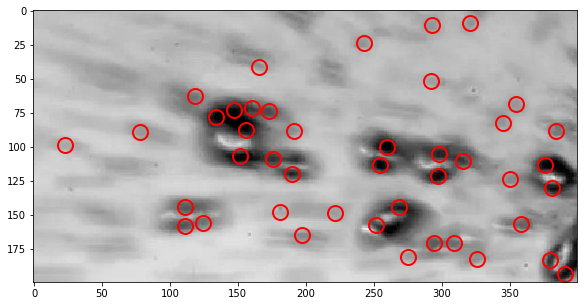

In [19]:
tp.annotate(f, frames[0]);

There are more options for controling and optimizing feature-finding. You can review them in the documentation, where the most comprehensive description is in the API reference. Or, pull them up as you work by typing tp.locate? into IPython.

http://soft-matter.github.io/trackpy/v0.4.2/

Check for subpixel accuracy

As Eric Weeks points out in his related tutorial, a quick way to check for subpixel accuracy is to check that the decimal part of the x and/or y positions are evenly distributed. Trackpy provides a convenience plotting function for this called subpx_bias:

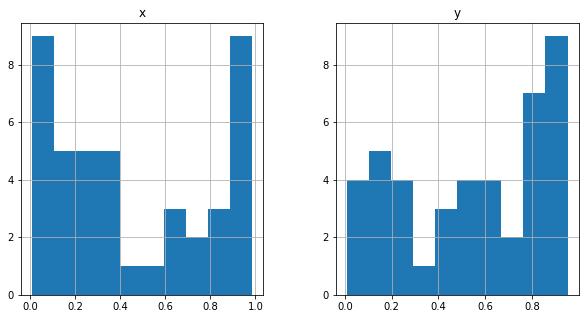

In [20]:
tp.subpx_bias(f);

If we use a mask size that is too small, the histogram often shows a dip in the middle.

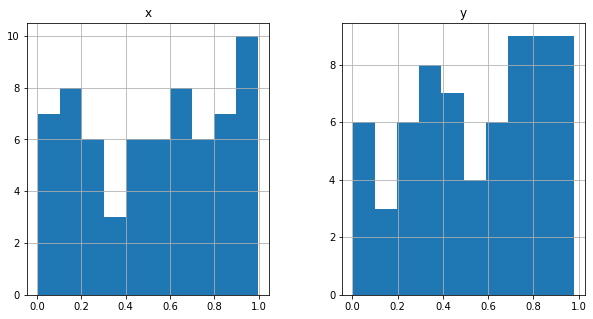

In [27]:
tp.subpx_bias(tp.locate(frames[0], 15, invert=True, minmass=100));

Locate features in all frames

Or, to start, just explore a subset of the frames.

/Users/georgedamoulakis/Desktop/Screen Shot 2020-06-11 at 9.03.39 PM.png

In [28]:
from IPython.display import Image
Image("/Users/georgedamoulakis/Desktop/Screen Shot 2020-06-11 at 9.03.39 PM.png")

FileNotFoundError: No such file or directory: '/Users/georgedamoulakis/Desktop/Screen Shot 2020-06-11 at 9.03.39 PM.png'

FileNotFoundError: No such file or directory: '/Users/georgedamoulakis/Desktop/Screen Shot 2020-06-11 at 9.03.39 PM.png'

<IPython.core.display.Image object>

We'll locate features in the first 10 rames from this video. We use tp.batch, which calls tp.locate on each frame and collects the results.

In [29]:
f = tp.batch(frames[:10], 17, minmass=300, invert=True);

Frame 9: 57 features


As each frame is analyzed, tp.batch reports the frame number and how many features were found. If this number runs unexpectedly low or high, you may wish to interrupt it and try different parameters.

If your images are small, you may find that printing this number actually slows down batch significantly! In that case you can run tp.quiet() to turn it off.

# Step 3: Link features into particle trajectories

We have the locations of the particles in each frame. Next we'll track particles from frame to frame, giving each one a number for identification.

First, we must must specify a maximum displacement, the farthest a particle can travel between frames. We should choose the smallest reasonable value because a large value slows computation time considerably. In this case, 5 pixels is reasonable.

Second, we allow for the possibility that a particle might be missed for a few frames and then seen again. (Perhaps its "mass" slipped below our cutoff due to noise in the video.) Memory keeps track of disappeared particles and maintains their ID for up to some number of frames after their last appearance. Here we use 2 frames.

In [30]:
# tp.quiet()  # Turn off progress reports for best performance
t = tp.link(f, 5, memory=2)

Frame 9: 57 trajectories present.


The result is the features DataFrame f with an additional column, particle, identifying each feature with a label. We denote this new DataFrame t.

In [31]:
t.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,6.970018,80.419280,428.587620,4.727442,0.356653,5.732952,29178.0,0.203892,0,0
29,112.965765,377.541474,3932.410027,4.922157,0.274153,37.165347,44817.0,0.025473,0,1
30,114.699005,73.691875,1053.479441,5.137772,0.127013,8.698273,30316.0,0.135056,0,2
31,120.499437,190.172062,2632.215942,4.403315,0.453018,43.886740,37933.0,0.041432,0,3
32,121.723860,296.945510,4339.054277,4.541329,0.294916,50.410444,41979.0,0.030281,0,4


Filter spurious trajectories

We have more filtering to do. Ephemeral trajectories — seen only for a few frames — are usually spurious and never useful. The convenience function filter_stubs keeps only trajectories that last for a given number of frames.

In [32]:
t1 = tp.filter_stubs(t, 2)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 430
After: 99


We can also filter trajectories by their particles' appearance. At this stage, with trajectories linked, we can look at a feature's "average appearance" throughout its trajectory, giving a more accurate picture.

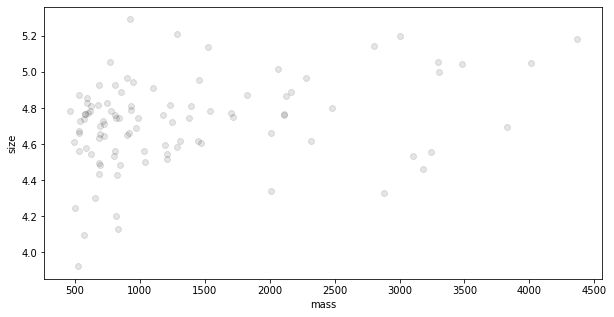

In [33]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass

The particles with especially low mass, or that are especially large or non-circular (eccentric), are probably out of focus or aggregated, respectively. It is best to experiment by trial and error, filtering out regions of mass-size space and looking at the results using tp.annotate. In the end, we need to separate the good particles from the spurious ones, and it doesn't matter how we get it done.

In [34]:
t2 = t1[((t1['mass'] > 11) & (t1['size'] < 20) &
         (t1['ecc'] < 2))]

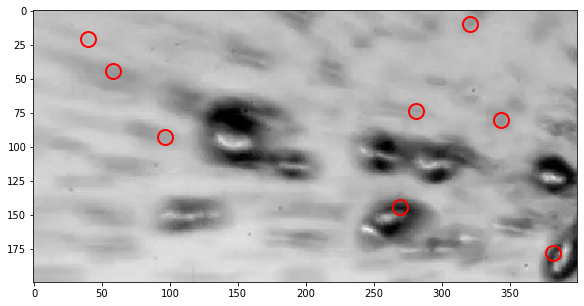

In [35]:
plt.figure()
tp.annotate(t2[t2['frame'] == 0], frames[0]);

Trace the trajectories using plot_traj():

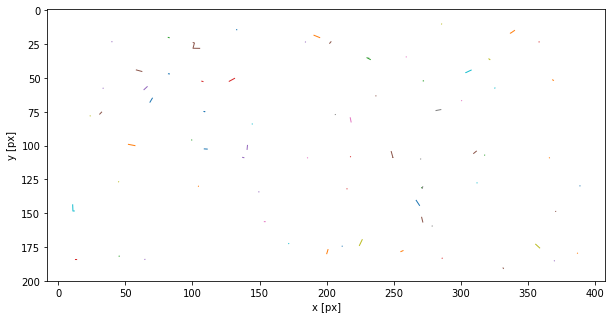

In [36]:
plt.figure()
tp.plot_traj(t2);

Remove overall drift

Compute the overall drifting motion, which we will subtract away, adopting the reference frame of the particles' average position.

In [37]:
d = tp.compute_drift(t2)

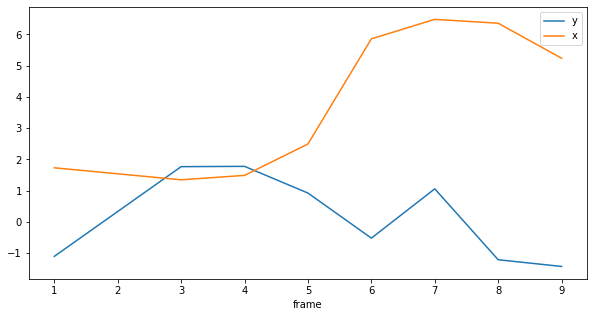

In [38]:
d.plot()
plt.show()

In [39]:
tm = tp.subtract_drift(t2.copy(), d)

With the overall drifting motion subtracted out, we plot the trajectories again. We observe nice random walks.

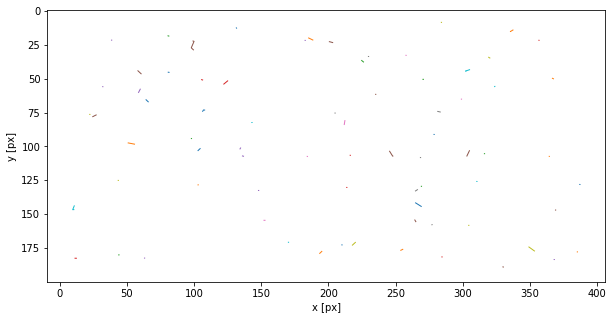

In [40]:
ax = tp.plot_traj(tm)
plt.show()